# Fruits-360 Pipeline (Color Histogram Baseline)
Baseline notebook using color histogram features and classic ML models.

**Key knobs:** `size`, `batch`, `RANDOM_STATE`, `color_bins`, `k_list`, `C_list`, `rf_depth_list`.

In [ ]:
import os
import random
import numpy as np
import torch
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as T
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from utils.pipeline_utils import (
    download_dataset,
    FruitFolderDataset,
    dataloader_to_numpy,
    save_checkpoint,
    color_hist_features,
 )
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

## Data: import dataset
Downloads Fruits-360 if missing and sets path variables.

**Change here:** `ROOT_DIR`, `GITHUB_REPO`, `CLONE_DIR`.

In [ ]:
ROOT_DIR = "dataset/fruit360"
TRAIN_DIR = os.path.join(ROOT_DIR, "Training")
TEST_DIR = os.path.join(ROOT_DIR, "Test")

GITHUB_REPO = "https://github.com/fruits-360/fruits-360-100x100"
CLONE_DIR = "dataset/fruits-360-100x100"

if not os.path.exists(ROOT_DIR):
    download_dataset(
        root_dir=ROOT_DIR,
        train_dir=TRAIN_DIR,
        test_dir=TEST_DIR,
        github_repo=GITHUB_REPO,
        clone_dir=CLONE_DIR,
    )

assert os.path.exists(TRAIN_DIR)
assert os.path.exists(TEST_DIR)

print(f"Train dir: {TRAIN_DIR}")
print(f"Test dir: {TEST_DIR}")

Train dir: dataset/fruit360/Training
Test dir: dataset/fruit360/Test


## Data: dataloader
Uses `FruitFolderDataset` to read folder-structured images.

**Change here:** `variety` flag when constructing the dataset.

## Config
Global parameters for image size, batch size, and seed.

**Change here:** `size`, `batch`, `RANDOM_STATE`.

In [4]:
size = 32
batch = 128
RANDOM_STATE = 42

## Utils: checkpointing
Checkpoints saved under artifacts/checkpoints via `save_checkpoint`.

**Change here:** pass a custom `run_dir` in `save_checkpoint` if needed.

## Data: train/val/test split
Splits dataset and builds loaders.

**Change here:** train/val ratio and `variety` label mode.

In [ ]:
val_transform = T.Compose([
    T.Resize((size, size)),
    T.ToTensor()
])

full_train_dataset_fg = FruitFolderDataset(TRAIN_DIR, transform=val_transform, variety=False)
test_dataset_fg = FruitFolderDataset(TEST_DIR, transform=val_transform, variety=False)

train_size_fg = int(0.7 * len(full_train_dataset_fg))
val_size_fg = len(full_train_dataset_fg) - train_size_fg

train_dataset_fg, val_dataset_fg = random_split(
    full_train_dataset_fg,
    [train_size_fg, val_size_fg],
    generator=torch.Generator().manual_seed(RANDOM_STATE)
)

train_loader_fg = DataLoader(train_dataset_fg, batch_size=batch, shuffle=True)
val_loader_fg = DataLoader(val_dataset_fg, batch_size=batch, shuffle=False)
test_loader_fg = DataLoader(test_dataset_fg, batch_size=batch, shuffle=False)

print("All -> Train:", len(train_dataset_fg),
      "Val:", len(val_dataset_fg),
      "Test:", len(test_dataset_fg),
      "Classes:", len(full_train_dataset_fg.label_to_idx))

Training -> 130344 images, 79 classes
Test -> 43442 images, 79 classes
Fine-grained -> Train: 91240 Val: 39104 Test: 43442 Classes: 79


## Data: loaders to NumPy
Converts loaders to NumPy arrays for feature extraction.

**Change here:** keep as-is; adjust `batch` above for memory/speed.

In [ ]:
X_train_np, y_train_np = dataloader_to_numpy(train_loader_fg)
X_val_np, y_val_np = dataloader_to_numpy(val_loader_fg)
X_test_np, y_test_np = dataloader_to_numpy(test_loader_fg)

print("Train:", X_train_np.shape, y_train_np.shape)
print("Val:", X_val_np.shape, y_val_np.shape)
print("Test:", X_test_np.shape, y_test_np.shape)

Train: (91240, 3, 32, 32) (91240,)
Val: (39104, 3, 32, 32) (39104,)
Test: (43442, 3, 32, 32) (43442,)


## EDA
Quick class distribution and random sample visualization.

**Change here:** `n_show` or plotting settings.

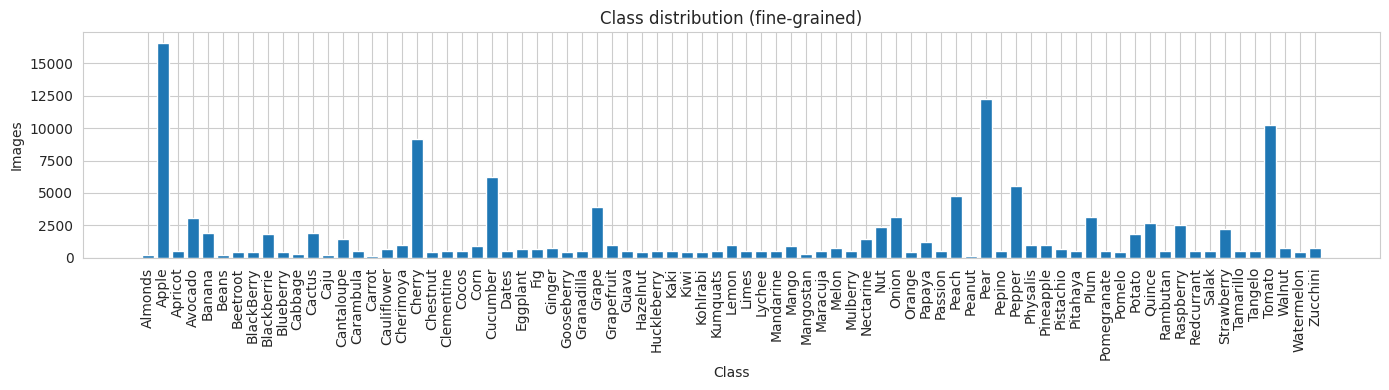

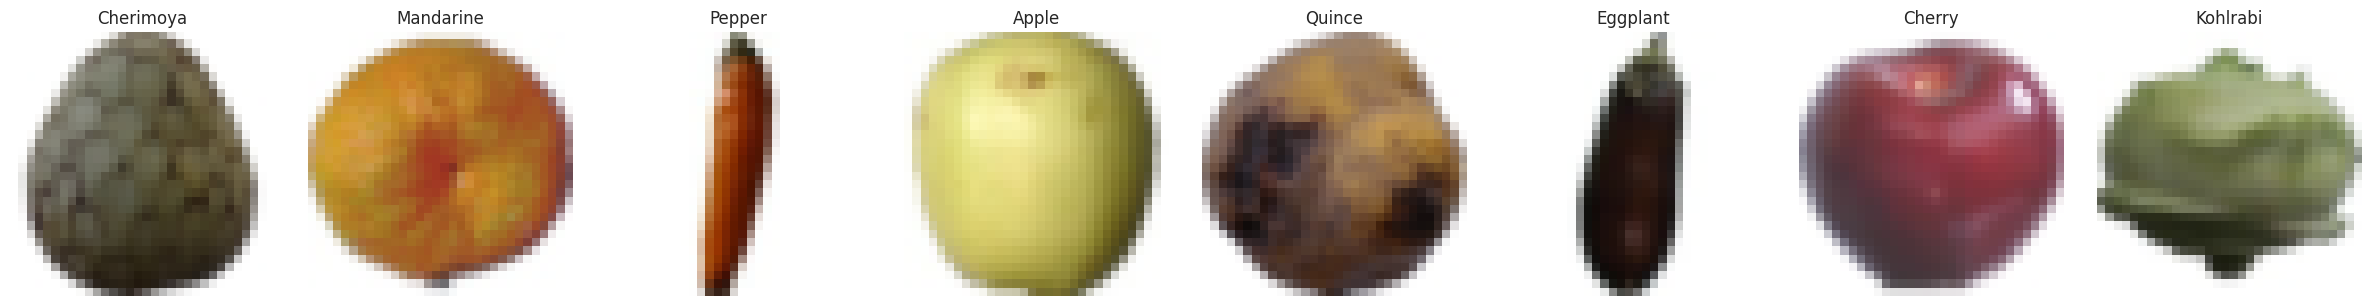

In [ ]:
label_counts = {}
for _, lbl in full_train_dataset_fg.samples:
    label_counts[lbl] = label_counts.get(lbl, 0) + 1

labels_sorted = sorted(label_counts.keys())
counts_sorted = [label_counts[l] for l in labels_sorted]

plt.figure(figsize=(14, 4))
plt.bar(labels_sorted, counts_sorted)
plt.title("Class distribution")
plt.xlabel("Class")
plt.ylabel("Images")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Random sample images
n_show = 8
indices = random.sample(range(len(train_dataset_fg)), n_show)
fig, axes = plt.subplots(1, n_show, figsize=(3*n_show, 3))
for ax, idx in zip(axes, indices):
    img, label_idx = train_dataset_fg[idx]
    img_np = img.permute(1, 2, 0).numpy()
    ax.imshow(img_np)
    ax.set_title(full_train_dataset_fg.idx_to_label[int(label_idx)])
    ax.axis('off')
plt.tight_layout()
plt.show()

## Features: color histogram
Computes HSV color histograms as fixed-size features.

**Change here:** `bins` and `img_shape` when calling `color_hist_features`.

In [ ]:
X_train_color = color_hist_features(X_train_np, bins=16, img_shape=(3, size, size))
X_val_color   = color_hist_features(X_val_np,   bins=16, img_shape=(3, size, size))
X_test_color  = color_hist_features(X_test_np,  bins=16, img_shape=(3, size, size))

print(X_train_color.shape)
print(X_val_color.shape)
print(X_test_color.shape)

(91240, 48)
(39104, 48)
(43442, 48)


## Models: kNN/SVM/RF on color hist
Trains classic ML models on standardized color hist features and saves checkpoints.

**Change here:** `k_list`, `C_list`, `rf_depth_list`, and RF params.

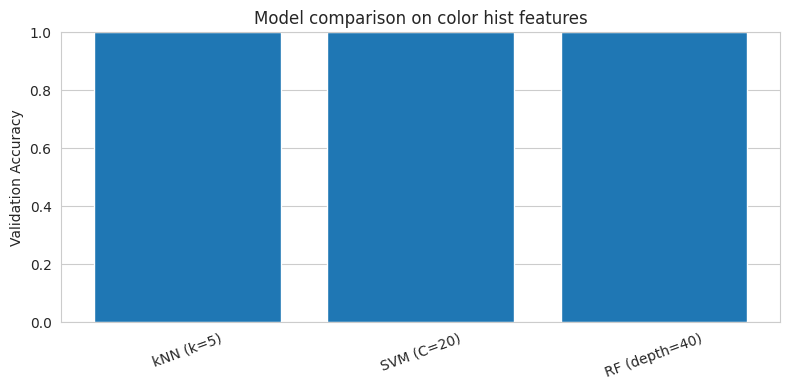

[('kNN (k=5)', 0.9996675531914894), ('SVM (C=20)', 1.0), ('RF (depth=40)', 0.9998209901800328)]
Saved checkpoints: [PosixPath('artifacts/checkpoints/fruit360/color_hist/knn/20260211-114401_efd2c1b4'), PosixPath('artifacts/checkpoints/fruit360/color_hist/svm/20260211-114401_5ae17476')]


In [11]:
scaler_color = StandardScaler()
X_train_color_std = scaler_color.fit_transform(X_train_color)
X_val_color_std = scaler_color.transform(X_val_color)

k_list = [5, 7, 9, 11]
C_list = [10, 20, 40]
rf_depth_list = [20, 30, 40]

results = []

# kNN
best_knn_acc = 0.0
best_k = None
best_knn_model = None
for k in k_list:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_color_std, y_train_np)
    y_val_pred = knn.predict(X_val_color_std)
    acc = accuracy_score(y_val_np, y_val_pred)
    if acc > best_knn_acc:
        best_knn_acc = acc
        best_k = k
        best_knn_model = knn
results.append((f"kNN (k={best_k})", best_knn_acc))

# SVM
best_svm_acc = 0.0
best_C = None
best_svm_model = None
for C in C_list:
    svm = SVC(kernel="rbf", C=C)
    svm.fit(X_train_color_std, y_train_np)
    y_val_pred = svm.predict(X_val_color_std)
    acc = accuracy_score(y_val_np, y_val_pred)
    if acc > best_svm_acc:
        best_svm_acc = acc
        best_C = C
        best_svm_model = svm
results.append((f"SVM (C={best_C})", best_svm_acc))

# Random Forest
best_rf_acc = 0.0
best_depth = None
best_rf_model = None
for depth in rf_depth_list:
    rf = RandomForestClassifier(
        n_estimators=300,
        max_depth=depth,
        max_features="sqrt",
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
    rf.fit(X_train_color_std, y_train_np)
    y_val_pred = rf.predict(X_val_color_std)
    acc = accuracy_score(y_val_np, y_val_pred)
    if acc > best_rf_acc:
        best_rf_acc = acc
        best_depth = depth
        best_rf_model = rf
results.append((f"RF (depth={best_depth})", best_rf_acc))

# Plot results
labels, accs = zip(*results)
plt.figure(figsize=(8, 4))
plt.bar(labels, accs)
plt.ylabel("Validation Accuracy")
plt.title("Model comparison on color hist features")
plt.ylim(0, 1)
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

print(results)

# Save checkpoints (best kNN + best SVM only)
color_bins = 16
meta_base = {
    "task": "fruit360",
    "split": "All",
    "feature": "color_hist",
    "img_size": size,
    "bins": color_bins,
    "seed": RANDOM_STATE,
    "n_classes": len(full_train_dataset_fg.label_to_idx),
    "labels": full_train_dataset_fg.labels,
    "label_to_idx": full_train_dataset_fg.label_to_idx,
}

ckpt_paths = []
if best_knn_model is not None:
    ckpt_paths.append(
        save_checkpoint(
            best_knn_model,
            scaler_color,
            {
                **meta_base,
                "model": "knn",
                "params": {"n_neighbors": best_k},
            },
            save_meta=False,
        )
    )
if best_svm_model is not None:
    ckpt_paths.append(
        save_checkpoint(
            best_svm_model,
            scaler_color,
            {
                **meta_base,
                "model": "svm",
                "params": {"kernel": "rbf", "C": best_C},
            },
            save_meta=False,
        )
    )
print("Saved checkpoints:", ckpt_paths)